# Phase 4b: Hyperparameter Tuning with Optuna

This notebook uses Optuna to find optimal hyperparameters for our advanced models.

**Objectives:**
- Use Optuna for automated hyperparameter optimization
- Tune LightGBM, XGBoost, and CatBoost independently
- Use time-series CV for robust evaluation
- Compare tuned results to manually specified hyperparameters
- Save best hyperparameters for final model training

**Strategy:**
- Each model gets its own Optuna study
- Use pruning to stop unpromising trials early
- Target metric: RMSPE (minimize)
- Budget: 50-100 trials per model (adjustable)

## Setup

In [ ]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from optuna.visualization import plot_optimization_history, plot_param_importances

from evaluation.cv import (
    make_time_series_folds,
    filter_open_stores,
    remove_missing_features
)
from evaluation.metrics import rmspe
from models.train_baselines import get_feature_columns
from utils.io import read_parquet, ensure_dir

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Ensure output directories
ensure_dir('../outputs/tuning')

print("Setup complete!")

## 1. Load Data and Create CV Folds

In [ ]:
# Load featured data
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

In [ ]:
# Load CV config
with open('../config/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

cv_config = params['cv']

print("Cross-Validation Configuration:")
print(f"  N folds: {cv_config['n_folds']}")
print(f"  Fold length: {cv_config['fold_length_days']} days")

In [ ]:
# Filter and create folds
df_open = filter_open_stores(df)

# Create folds
folds = make_time_series_folds(
    df_open,
    n_folds=cv_config['n_folds'],
    fold_length_days=cv_config['fold_length_days'],
    min_train_days=cv_config['min_train_days']
)

feature_cols = get_feature_columns(df_open)

print(f"\nCreated {len(folds)} folds")
print(f"Features: {len(feature_cols)}")

## 2. Define Hyperparameter Search Spaces

For each model, we define the hyperparameters to tune and their search ranges.

In [ ]:
# Number of trials per model
N_TRIALS = 50  # Increase to 100+ for better results (but takes longer)

print(f"Hyperparameter tuning configuration:")
print(f"  Trials per model: {N_TRIALS}")
print(f"  CV folds: {len(folds)}")
print(f"  Estimated time per model: {N_TRIALS * len(folds) * 10 / 60:.0f} minutes (rough estimate)")

## 3. Tune LightGBM

In [ ]:
def objective_lightgbm(trial):
    """
    Optuna objective function for LightGBM hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'verbose': -1,
        'seed': 42
    }
    
    # Evaluate using CV
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Prepare data
        X_train = train_data[valid_features]
        y_train = train_data['Sales']
        X_val = val_data[valid_features]
        y_val = val_data['Sales']
        
        # Create LightGBM datasets
        train_set = lgb.Dataset(X_train, label=y_train)
        val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)
        
        # Train model
        model = lgb.train(
            params,
            train_set,
            num_boost_round=2000,
            valid_sets=[val_set],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        # Predict and evaluate
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        score = rmspe(y_val.values, y_pred)
        fold_scores.append(score)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_scores), fold_idx)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_scores)

In [ ]:
# Create and run LightGBM study
print("="*60)
print("Tuning LightGBM Hyperparameters")
print("="*60)

study_lgb = optuna.create_study(
    direction='minimize',
    study_name='lightgbm_tuning',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
)

study_lgb.optimize(objective_lightgbm, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nBest RMSPE: {study_lgb.best_value:.6f}")
print(f"\nBest hyperparameters:")
for key, value in study_lgb.best_params.items():
    print(f"  {key}: {value}")

## 4. Tune XGBoost

In [ ]:
def objective_xgboost(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'seed': 42,
        'verbosity': 0
    }
    
    # Evaluate using CV
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Prepare data
        X_train = train_data[valid_features].copy()
        y_train = train_data['Sales']
        X_val = val_data[valid_features].copy()
        y_val = val_data['Sales']
        
        # Convert categoricals to codes for XGBoost
        for col in X_train.columns:
            if X_train[col].dtype.name == 'category':
                X_train[col] = X_train[col].cat.codes
                X_val[col] = X_val[col].cat.codes
        
        # Create XGBoost datasets
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Train model
        evals = [(dval, 'valid')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=2000,
            evals=evals,
            early_stopping_rounds=100,
            verbose_eval=False
        )
        
        # Predict and evaluate
        y_pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        score = rmspe(y_val.values, y_pred)
        fold_scores.append(score)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_scores), fold_idx)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_scores)

In [ ]:
# Create and run XGBoost study
print("="*60)
print("Tuning XGBoost Hyperparameters")
print("="*60)

study_xgb = optuna.create_study(
    direction='minimize',
    study_name='xgboost_tuning',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
)

study_xgb.optimize(objective_xgboost, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nBest RMSPE: {study_xgb.best_value:.6f}")
print(f"\nBest hyperparameters:")
for key, value in study_xgb.best_params.items():
    print(f"  {key}: {value}")

## 5. Tune CatBoost

In [ ]:
def objective_catboost(trial):
    """
    Optuna objective function for CatBoost hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'depth': trial.suggest_int('depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False,
        'random_seed': 42
    }
    
    # Identify categorical features
    cat_features = [
        col for col in feature_cols
        if df_open[col].dtype in ['object', 'category']
    ]
    
    # Evaluate using CV
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Update categorical features
        valid_cat_features = [col for col in cat_features if col in valid_features]
        
        # Prepare data
        X_train = train_data[valid_features]
        y_train = train_data['Sales']
        X_val = val_data[valid_features]
        y_val = val_data['Sales']
        
        # Create CatBoost datasets
        train_pool = cb.Pool(X_train, label=y_train, cat_features=valid_cat_features)
        val_pool = cb.Pool(X_val, label=y_val, cat_features=valid_cat_features)
        
        # Train model
        model = cb.CatBoost(params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=100,
            verbose=False
        )
        
        # Predict and evaluate
        y_pred = model.predict(val_pool)
        score = rmspe(y_val.values, y_pred)
        fold_scores.append(score)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_scores), fold_idx)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_scores)

In [ ]:
# Create and run CatBoost study
print("="*60)
print("Tuning CatBoost Hyperparameters")
print("="*60)

study_cb = optuna.create_study(
    direction='minimize',
    study_name='catboost_tuning',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
)

study_cb.optimize(objective_catboost, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nBest RMSPE: {study_cb.best_value:.6f}")
print(f"\nBest hyperparameters:")
for key, value in study_cb.best_params.items():
    print(f"  {key}: {value}")

## 6. Compare Results

In [ ]:
# Load manual hyperparameter results
with open("../outputs/metrics/advanced/lightgbm_tuned_cv_results.json", "r") as f:
    manual_lgb = json.load(f)

with open("../outputs/metrics/advanced/xgboost_cv_results.json", "r") as f:
    manual_xgb = json.load(f)

with open("../outputs/metrics/advanced/catboost_cv_results.json", "r") as f:
    manual_cb = json.load(f)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'Manual RMSPE': [
        float(manual_lgb['mean_score']),
        float(manual_xgb['mean_score']),
        float(manual_cb['mean_score'])
    ],
    'Optuna RMSPE': [
        study_lgb.best_value,
        study_xgb.best_value,
        study_cb.best_value
    ]
})

comparison['Improvement (%)'] = (
    (comparison['Manual RMSPE'] - comparison['Optuna RMSPE']) / 
    comparison['Manual RMSPE'] * 100
)

print("="*70)
print("Hyperparameter Tuning Results")
print("="*70)
print("\nComparison: Manual vs Optuna-tuned")
display(comparison)

print(f"\nBest overall model: {comparison.loc[comparison['Optuna RMSPE'].idxmin(), 'Model']}")
print(f"Best RMSPE: {comparison['Optuna RMSPE'].min():.6f}")

# Gap to target
target = 0.09856
best_score = comparison['Optuna RMSPE'].min()
gap = best_score - target
gap_pct = (gap / target) * 100

print(f"\nGap to target (0.09856): {gap:.6f} ({gap_pct:+.2f}%)")

## 7. Visualize Optimization

In [ ]:
# Optimization history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LightGBM
ax = axes[0]
trials_lgb = study_lgb.trials
ax.plot([t.number for t in trials_lgb], [t.value for t in trials_lgb], 'o-', alpha=0.5)
ax.axhline(y=study_lgb.best_value, color='r', linestyle='--', label=f'Best: {study_lgb.best_value:.6f}')
ax.axhline(y=target, color='g', linestyle='--', label=f'Target: {target:.6f}')
ax.set_xlabel('Trial')
ax.set_ylabel('RMSPE')
ax.set_title('LightGBM Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# XGBoost
ax = axes[1]
trials_xgb = study_xgb.trials
ax.plot([t.number for t in trials_xgb], [t.value for t in trials_xgb], 'o-', alpha=0.5)
ax.axhline(y=study_xgb.best_value, color='r', linestyle='--', label=f'Best: {study_xgb.best_value:.6f}')
ax.axhline(y=target, color='g', linestyle='--', label=f'Target: {target:.6f}')
ax.set_xlabel('Trial')
ax.set_ylabel('RMSPE')
ax.set_title('XGBoost Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# CatBoost
ax = axes[2]
trials_cb = study_cb.trials
ax.plot([t.number for t in trials_cb], [t.value for t in trials_cb], 'o-', alpha=0.5)
ax.axhline(y=study_cb.best_value, color='r', linestyle='--', label=f'Best: {study_cb.best_value:.6f}')
ax.axhline(y=target, color='g', linestyle='--', label=f'Target: {target:.6f}')
ax.set_xlabel('Trial')
ax.set_ylabel('RMSPE')
ax.set_title('CatBoost Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/tuning/optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/tuning/optimization_history.png")

In [ ]:
# Comparison bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['Manual RMSPE'], width, label='Manual', alpha=0.7)
ax.bar(x + width/2, comparison['Optuna RMSPE'], width, label='Optuna', alpha=0.7)

ax.axhline(y=target, color='red', linestyle='--', label='Target (0.09856)', linewidth=2)
ax.set_ylabel('RMSPE')
ax.set_title('Manual vs Optuna-Tuned Hyperparameters')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/tuning/manual_vs_optuna.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/tuning/manual_vs_optuna.png")

## 8. Save Best Hyperparameters

In [17]:
# Save best hyperparameters for each model
best_params = {
    'lightgbm': study_lgb.best_params,
    'xgboost': study_xgb.best_params,
    'catboost': study_cb.best_params,
    'scores': {
        'lightgbm': study_lgb.best_value,
        'xgboost': study_xgb.best_value,
        'catboost': study_cb.best_value
    }
}

with open('../outputs/tuning/best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("Saved best hyperparameters to: outputs/tuning/best_hyperparameters.json")
print("\nThese can be used in config/params.yaml for final model training")

Saved best hyperparameters to: outputs/tuning/best_hyperparameters.json

These can be used in config/params.yaml for final model training


## 9. Ensemble the Best Tuned Models

Now let's create an ensemble combining the best tuned models to see if we can improve performance further.

In [18]:
def train_ensemble_cv(folds, lgb_params, xgb_params, cb_params, feature_cols):
    """
    Train an ensemble of LightGBM, XGBoost, and CatBoost using their best hyperparameters.
    Returns out-of-fold predictions for each model and the ensemble.
    """
    fold_scores = {
        'lgb': [],
        'xgb': [],
        'cb': [],
        'simple_avg': [],
        'weighted_avg': []
    }
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        print(f"\nFold {fold_idx + 1}/{len(folds)}")
        
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Prepare data
        y_train = train_data['Sales']
        y_val = val_data['Sales']
        
        # ===== Train LightGBM =====
        X_train_lgb = train_data[valid_features]
        X_val_lgb = val_data[valid_features]
        
        train_set = lgb.Dataset(X_train_lgb, label=y_train)
        val_set = lgb.Dataset(X_val_lgb, label=y_val, reference=train_set)
        
        lgb_model = lgb.train(
            lgb_params,
            train_set,
            num_boost_round=2000,
            valid_sets=[val_set],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        pred_lgb = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)
        score_lgb = rmspe(y_val.values, pred_lgb)
        fold_scores['lgb'].append(score_lgb)
        print(f"  LightGBM RMSPE: {score_lgb:.6f}")
        
        # ===== Train XGBoost =====
        X_train_xgb = train_data[valid_features].copy()
        X_val_xgb = val_data[valid_features].copy()
        
        # Convert categoricals to codes
        for col in X_train_xgb.columns:
            if X_train_xgb[col].dtype.name == 'category':
                X_train_xgb[col] = X_train_xgb[col].cat.codes
                X_val_xgb[col] = X_val_xgb[col].cat.codes
        
        dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
        dval = xgb.DMatrix(X_val_xgb, label=y_val)
        
        evals = [(dval, 'valid')]
        xgb_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=2000,
            evals=evals,
            early_stopping_rounds=100,
            verbose_eval=False
        )
        
        pred_xgb = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
        score_xgb = rmspe(y_val.values, pred_xgb)
        fold_scores['xgb'].append(score_xgb)
        print(f"  XGBoost RMSPE: {score_xgb:.6f}")
        
        # ===== Train CatBoost =====
        X_train_cb = train_data[valid_features]
        X_val_cb = val_data[valid_features]
        
        # Identify categorical features
        cat_features = [
            col for col in valid_features
            if df_open[col].dtype in ['object', 'category']
        ]
        
        train_pool = cb.Pool(X_train_cb, label=y_train, cat_features=cat_features)
        val_pool = cb.Pool(X_val_cb, label=y_val, cat_features=cat_features)
        
        cb_model = cb.CatBoost(cb_params)
        cb_model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=100,
            verbose=False
        )
        
        pred_cb = cb_model.predict(val_pool)
        score_cb = rmspe(y_val.values, pred_cb)
        fold_scores['cb'].append(score_cb)
        print(f"  CatBoost RMSPE: {score_cb:.6f}")
        
        # ===== Ensemble Predictions =====
        # Simple average
        pred_simple_avg = (pred_lgb + pred_xgb + pred_cb) / 3
        score_simple_avg = rmspe(y_val.values, pred_simple_avg)
        fold_scores['simple_avg'].append(score_simple_avg)
        print(f"  Simple Average RMSPE: {score_simple_avg:.6f}")
        
        # Weighted average (inversely proportional to CV scores)
        w_lgb = 1 / study_lgb.best_value
        w_xgb = 1 / study_xgb.best_value
        w_cb = 1 / study_cb.best_value
        total_weight = w_lgb + w_xgb + w_cb
        
        pred_weighted_avg = (
            (w_lgb / total_weight) * pred_lgb +
            (w_xgb / total_weight) * pred_xgb +
            (w_cb / total_weight) * pred_cb
        )
        score_weighted_avg = rmspe(y_val.values, pred_weighted_avg)
        fold_scores['weighted_avg'].append(score_weighted_avg)
        print(f"  Weighted Average RMSPE: {score_weighted_avg:.6f}")
    
    return fold_scores

# Prepare best hyperparameters for each model
lgb_params_best = {
    **study_lgb.best_params,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'seed': 42
}

xgb_params_best = {
    **study_xgb.best_params,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'verbosity': 0
}

cb_params_best = {
    **study_cb.best_params,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': False,
    'random_seed': 42
}

print("Training ensemble with best hyperparameters...")
print("=" * 60)

ensemble_scores = train_ensemble_cv(
    folds,
    lgb_params_best,
    xgb_params_best,
    cb_params_best,
    feature_cols
)

Training ensemble with best hyperparameters...

Fold 1/5
2025-12-01 20:29:07 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-01 20:29:07 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-01 20:29:07 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 20:29:07 - evaluation.cv - INFO - Remaining: 38,761 complete rows
  LightGBM RMSPE: 0.144990
  XGBoost RMSPE: 0.140757
  CatBoost RMSPE: 0.152122
  Simple Average RMSPE: 0.141152
  Weighted Average RMSPE: 0.141061

Fold 2/5
2025-12-01 20:29:43 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-01 20:29:43 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-01 20:29:43 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 20:29:43 - evaluation.cv - INFO - Remaining: 40,164 complete rows
  LightGBM RMSPE: 0.157433
  XGBoost RMSPE: 0.155957
  CatBoost RMSPE: 0.161914
  Simple Average RMSPE: 0

In [19]:
# Calculate mean scores across folds
mean_scores = {
    'LightGBM': np.mean(ensemble_scores['lgb']),
    'XGBoost': np.mean(ensemble_scores['xgb']),
    'CatBoost': np.mean(ensemble_scores['cb']),
    'Simple Average': np.mean(ensemble_scores['simple_avg']),
    'Weighted Average': np.mean(ensemble_scores['weighted_avg'])
}

std_scores = {
    'LightGBM': np.std(ensemble_scores['lgb']),
    'XGBoost': np.std(ensemble_scores['xgb']),
    'CatBoost': np.std(ensemble_scores['cb']),
    'Simple Average': np.std(ensemble_scores['simple_avg']),
    'Weighted Average': np.std(ensemble_scores['weighted_avg'])
}

# Create results dataframe
ensemble_results = pd.DataFrame({
    'Model': list(mean_scores.keys()),
    'Mean RMSPE': list(mean_scores.values()),
    'Std RMSPE': list(std_scores.values())
})

ensemble_results = ensemble_results.sort_values('Mean RMSPE')

print("=" * 70)
print("Ensemble Results")
print("=" * 70)
display(ensemble_results)

best_ensemble_model = ensemble_results.iloc[0]['Model']
best_ensemble_score = ensemble_results.iloc[0]['Mean RMSPE']

print(f"\nBest approach: {best_ensemble_model}")
print(f"Best RMSPE: {best_ensemble_score:.6f}")

# Compare to target
gap_ensemble = best_ensemble_score - target
gap_pct_ensemble = (gap_ensemble / target) * 100
print(f"\nGap to target (0.09856): {gap_ensemble:.6f} ({gap_pct_ensemble:+.2f}%)")

Ensemble Results


,Model,Mean RMSPE,Std RMSPE
1,XGBoost,0.122010,0.022183
4,Weighted Average,0.122063,0.022610
3,Simple Average,0.122121,0.022613
0,LightGBM,0.126549,0.020614
2,CatBoost,0.128262,0.023876



Best approach: XGBoost
Best RMSPE: 0.122010

Gap to target (0.09856): 0.023450 (+23.79%)


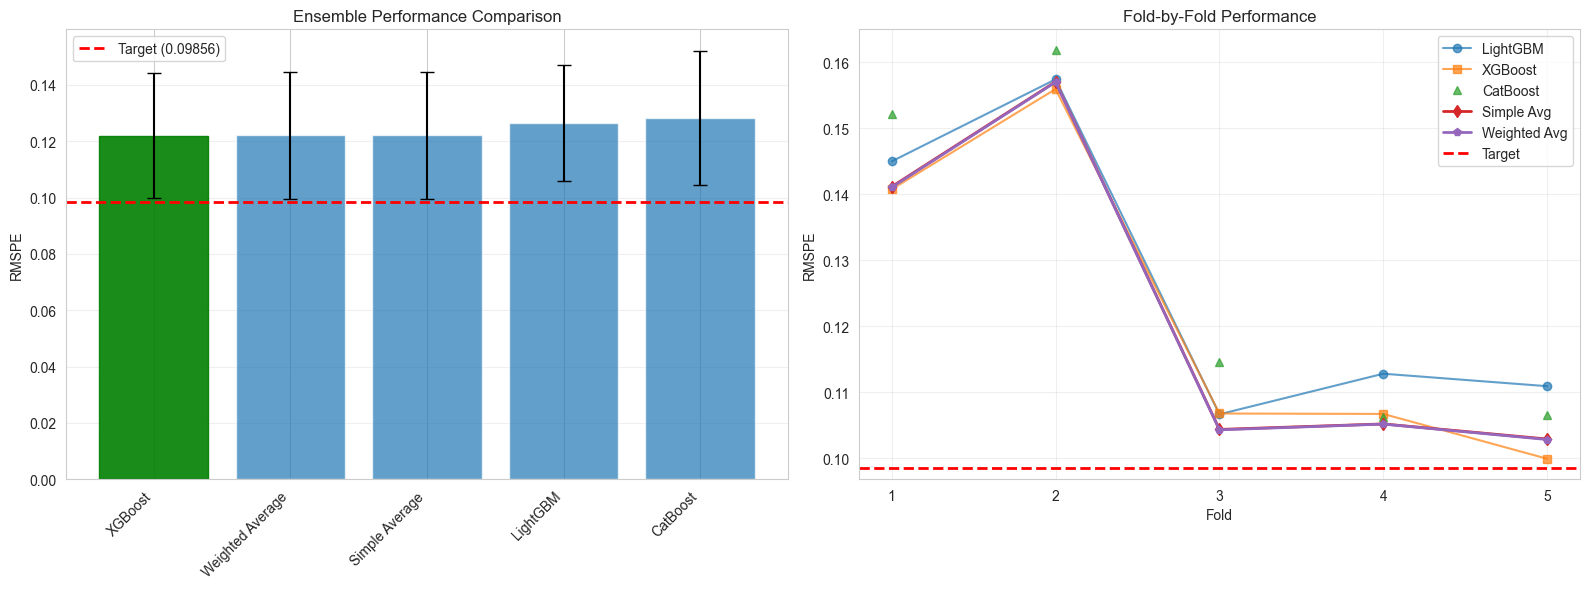

Saved: outputs/tuning/ensemble_comparison.png


In [20]:
# Visualize ensemble results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot with error bars
ax = axes[0]
x = np.arange(len(ensemble_results))
bars = ax.bar(x, ensemble_results['Mean RMSPE'], yerr=ensemble_results['Std RMSPE'], 
              capsize=5, alpha=0.7)

# Color the best model differently
bars[0].set_color('green')
bars[0].set_alpha(0.9)

ax.axhline(y=target, color='red', linestyle='--', label='Target (0.09856)', linewidth=2)
ax.set_ylabel('RMSPE')
ax.set_title('Ensemble Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(ensemble_results['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Fold-by-fold comparison
ax = axes[1]
fold_indices = np.arange(1, len(folds) + 1)

ax.plot(fold_indices, ensemble_scores['lgb'], 'o-', label='LightGBM', alpha=0.7)
ax.plot(fold_indices, ensemble_scores['xgb'], 's-', label='XGBoost', alpha=0.7)
ax.plot(fold_indices, ensemble_scores['cb'], '^', label='CatBoost', alpha=0.7)
ax.plot(fold_indices, ensemble_scores['simple_avg'], 'd-', label='Simple Avg', linewidth=2)
ax.plot(fold_indices, ensemble_scores['weighted_avg'], 'p-', label='Weighted Avg', linewidth=2)
ax.axhline(y=target, color='red', linestyle='--', label='Target', linewidth=2)

ax.set_xlabel('Fold')
ax.set_ylabel('RMSPE')
ax.set_title('Fold-by-Fold Performance')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(fold_indices)

plt.tight_layout()
plt.savefig('../outputs/tuning/ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/tuning/ensemble_comparison.png")

In [21]:
# Save ensemble results
ensemble_results_dict = {
    'models': {
        'lightgbm': {
            'mean_rmspe': float(mean_scores['LightGBM']),
            'std_rmspe': float(std_scores['LightGBM']),
            'fold_scores': [float(s) for s in ensemble_scores['lgb']]
        },
        'xgboost': {
            'mean_rmspe': float(mean_scores['XGBoost']),
            'std_rmspe': float(std_scores['XGBoost']),
            'fold_scores': [float(s) for s in ensemble_scores['xgb']]
        },
        'catboost': {
            'mean_rmspe': float(mean_scores['CatBoost']),
            'std_rmspe': float(std_scores['CatBoost']),
            'fold_scores': [float(s) for s in ensemble_scores['cb']]
        }
    },
    'ensembles': {
        'simple_average': {
            'mean_rmspe': float(mean_scores['Simple Average']),
            'std_rmspe': float(std_scores['Simple Average']),
            'fold_scores': [float(s) for s in ensemble_scores['simple_avg']],
            'description': 'Equal-weight average of LightGBM, XGBoost, and CatBoost'
        },
        'weighted_average': {
            'mean_rmspe': float(mean_scores['Weighted Average']),
            'std_rmspe': float(std_scores['Weighted Average']),
            'fold_scores': [float(s) for s in ensemble_scores['weighted_avg']],
            'description': 'Inverse-RMSPE weighted average',
            'weights': {
                'lightgbm': float((1/study_lgb.best_value) / (1/study_lgb.best_value + 1/study_xgb.best_value + 1/study_cb.best_value)),
                'xgboost': float((1/study_xgb.best_value) / (1/study_lgb.best_value + 1/study_xgb.best_value + 1/study_cb.best_value)),
                'catboost': float((1/study_cb.best_value) / (1/study_lgb.best_value + 1/study_xgb.best_value + 1/study_cb.best_value))
            }
        }
    },
    'best_approach': {
        'name': best_ensemble_model,
        'rmspe': float(best_ensemble_score),
        'gap_to_target': float(gap_ensemble),
        'gap_to_target_pct': float(gap_pct_ensemble)
    }
}

with open('../outputs/tuning/ensemble_results.json', 'w') as f:
    json.dump(ensemble_results_dict, f, indent=2)

print("Saved ensemble results to: outputs/tuning/ensemble_results.json")

Saved ensemble results to: outputs/tuning/ensemble_results.json


## 10. Summary

In [22]:
print("\n" + "="*70)
print("Hyperparameter Tuning & Ensemble Complete!")
print("="*70)

print(f"\n1. Hyperparameter Optimization:")
print(f"   Optimized {len(comparison)} models with {N_TRIALS} trials each")
print(f"\n   Individual Model Results:")
for idx, row in comparison.iterrows():
    print(f"     {row['Model']}:")
    print(f"       Manual:  {row['Manual RMSPE']:.6f}")
    print(f"       Optuna:  {row['Optuna RMSPE']:.6f}")
    print(f"       Improvement: {row['Improvement (%)']:.2f}%")

print(f"\n2. Ensemble Results:")
print(f"   Simple Average:   {mean_scores['Simple Average']:.6f}")
print(f"   Weighted Average: {mean_scores['Weighted Average']:.6f}")

print(f"\n3. Final Best Approach:")
print(f"   Method: {best_ensemble_model}")
print(f"   RMSPE: {best_ensemble_score:.6f}")
print(f"   Gap to target (0.09856): {gap_ensemble:.6f} ({gap_pct_ensemble:+.2f}%)")

print(f"\n4. Saved Outputs:")
print(f"   - Best hyperparameters: outputs/tuning/best_hyperparameters.json")
print(f"   - Ensemble results: outputs/tuning/ensemble_results.json")
print(f"   - Visualizations: outputs/tuning/*.png")

print("="*70)


Hyperparameter Tuning & Ensemble Complete!

1. Hyperparameter Optimization:
   Optimized 3 models with 50 trials each

   Individual Model Results:
     LightGBM:
       Manual:  0.136386
       Optuna:  0.126549
       Improvement: 7.21%
     XGBoost:
       Manual:  0.129474
       Optuna:  0.122010
       Improvement: 5.76%
     CatBoost:
       Manual:  0.135115
       Optuna:  0.128262
       Improvement: 5.07%

2. Ensemble Results:
   Simple Average:   0.122121
   Weighted Average: 0.122063

3. Final Best Approach:
   Method: XGBoost
   RMSPE: 0.122010
   Gap to target (0.09856): 0.023450 (+23.79%)

4. Saved Outputs:
   - Best hyperparameters: outputs/tuning/best_hyperparameters.json
   - Ensemble results: outputs/tuning/ensemble_results.json
   - Visualizations: outputs/tuning/*.png
